In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
sns.set(font_scale=1.5)

**************************************************

Parcel workplace param sweep

**************************************************

Get variables

In [85]:
df = pd.read_pickle('all_interventions.pkl',compression='bz2')
df['NRecovered'] = df['FracRecovered']*df['NStaff']
print(df.columns)

Index(['Group', 'NStaff', 'Iteration', 'FracRecovered', 'FomiteInfectionFrac',
       'CohortInfectionFrac', 'RandContactInfectionFrac', 'PairInfectionFrac',
       'RoomInfectionFrac', 'ExtIntroFrac', 'CustIntroFrac', 'CarShareInfFrac',
       'HouseShareInfFrac', 'CustomersInfected', 'IsolatorsFrac',
       'SympIsolatorsFrac', 'FPIsolatorsFrac', 'TPSympIsolatorsFrac',
       'TPAsympIsolatorsFrac', 'IndexCaseInfections', 'IndexCaseViralLoad',
       'IndexCaseInfectivity', 'OverallOutbreakLength', 'cohort_isolation',
       'is_testing', 'protocol', 'tperiod', 'specificity', 'new_comply_prob',
       'tD', 'SimType', 'TeamTimes', 'phi', 'TeamDistances', 'InfInit',
       'car_share_isolation', 'HouseShareFactor', 'CarShareFactor', 'Psusc',
       'delay', 'Pisol', 'NDteams', 'is_cohorts', 'p_contact',
       'house_share_isolation', 'test_pause', 'NOteams', 'TeamsOutside',
       'NLteams', 'NRecovered'],
      dtype='object')


In [88]:
dfall = df[df["Group"]=='All']
dfall['outbreak'] = (dfall['NRecovered'] > 4)
dfall['Ninfected'] = (dfall.loc[:,'FracRecovered']*dfall.loc[:,'NStaff'])
dfall['Introductions'] = (dfall["ExtIntroFrac"] + dfall["CustIntroFrac"])*dfall["NStaff"]
dfall['Secondary'] = dfall['Ninfected'] - dfall['Introductions']

/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [77]:
print(df["TeamDistances"])

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
279995    2.0
279996    2.0
279997    2.0
279998    2.0
279999    2.0
Name: TeamDistances, Length: 280000, dtype: float64


In [81]:
Nrows = len(df)
Conditions = np.array(["Office WFH","+ Distancing","+ Testing","+ House Share Isolation",\
                       "+ Car Share Isolation","+ Cohort Isolation"])
print(Nrows, len(Conditions))
BoolCond = np.zeros((Nrows,len(Conditions)),dtype=bool)
nda = np.arange(Nrows) + 2
nda[-1] = 1
nda[-2] = 0
npa = np.arange(Nrows) + 1
npa[-1] = 0
Group = df["Group"].to_numpy()
NStaff = df["NStaff"].to_numpy()
BoolCond[:,0] = ((Group == "Pickers") & (NStaff[npa] == 0)) + \
                ((Group == "Drivers") & (NStaff[nda] == 0)) + \
                ((Group == "Office") & (NStaff == 0)) + \
                ((Group == "All") & (NStaff < 68))
naa = np.arange(Nrows) - 2
Tdist = df["TeamDistances"].to_numpy()
BoolCond[:,1] = (Tdist > 1.5) + \
                ((Group == "All") & (Tdist[naa] > 1.5))
BoolCond[:,2] = df["is_testing"]
BoolCond[:,3] = df["house_share_isolation"]
BoolCond[:,4] = df["car_share_isolation"]
BoolCond[:,5] = df["cohort_isolation"]
NCond = np.sum(BoolCond,0)
CondOrder = np.flip(np.argsort(NCond))
print(NCond)
print(CondOrder)

280000 6
[240000 200000 160000 120000  80000  40000]
[0 1 2 3 4 5]


/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

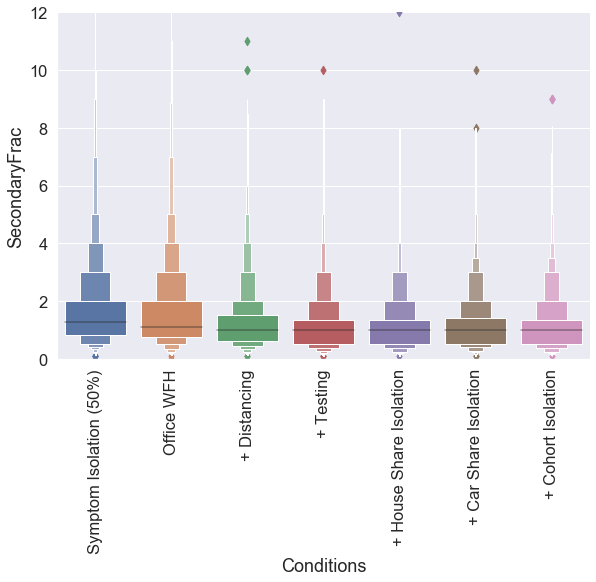

In [114]:
dfall['SecondaryFrac'] = dfall['Secondary']/dfall['Introductions']
dfall['Conditions'] = np.zeros(len(dfall),dtype=np.object)
Intros = dfall["Introductions"].to_numpy()
for i in np.arange(len(Conditions)+1):
    rowcond = np.zeros(len(Conditions),dtype = np.bool)
    for j in np.arange(i):
        rowcond[CondOrder[j]] = True
    rowbool = np.all(BoolCond == rowcond,1)
    rowboolall = rowbool[(Group=="All")]
    
    if i == 0:
        lab = "Symptom Isolation (50%)"
    else:
        lab = Conditions[i-1]
    dfall['Conditions'][rowboolall] = lab
    
    
dfallintros = dfall[Intros>0]
sp = sns.catplot(x="Conditions", y="SecondaryFrac", data=dfallintros, kind='boxen', \
                 height=6, aspect=1.5)
sp.set(ylim=(0,12))
sp.set_xticklabels(rotation=90)

Index case to outbreak relation

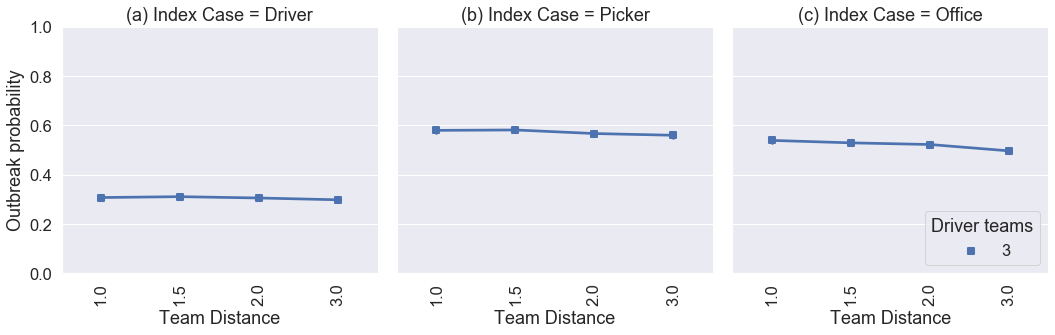

In [48]:
sp = sns.catplot(x='TeamDistances',y='outbreak', hue='NDteams',col='InfInit',data=dfNDT,kind='point',\
                 markers=["s","o","^","x"], linestyles=["-", "--",":","-."], legend=False)
sp.set(xlabel='Team Distance',ylim=(0,1.0))
axes = sp.axes.flatten()
axes[0].set_ylabel('Outbreak probability')
lab = ['a','b','c']
for i in range(3):
    axes[i].set_title('(%s) Index Case = %s'%(lab[i],job[i]))
sp.set_xticklabels(rotation=90)
plt.legend(loc='lower right',title='Driver teams')
plt.tight_layout()
sp.savefig('param_sweep_outbreak_probability_NDT.png')

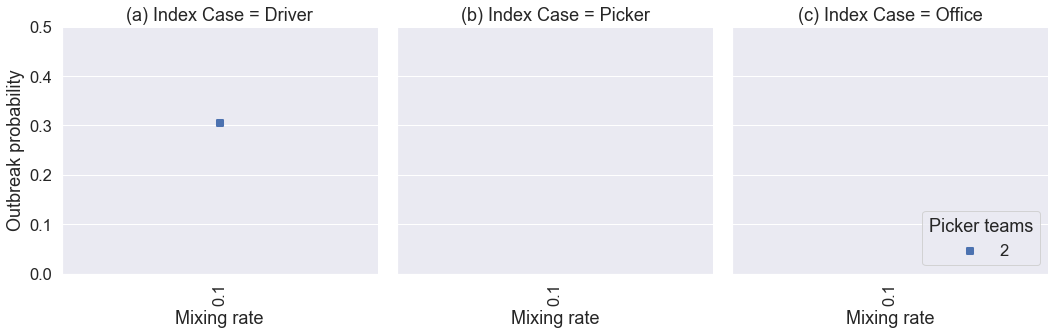

In [46]:
sp = sns.catplot(x='phi',y='outbreak', hue='NLteams',col='InfInit',data=dfNLT,kind='point',\
                 markers=["s","o","^","x"], linestyles=["-", "--",":","-."], legend=False)
sp.set(xlabel='Mixing rate',ylim=(0,0.5))
axes = sp.axes.flatten()
axes[0].set_ylabel('Outbreak probability')
lab = ['a','b','c']
for i in range(3):
    axes[i].set_title('(%s) Index Case = %s'%(lab[i],job[i]))
sp.set_xticklabels(rotation=90)
plt.legend(loc='lower right',title='Picker teams')
plt.tight_layout()
sp.savefig('param_sweep_outbreak_probability_NLT.png')

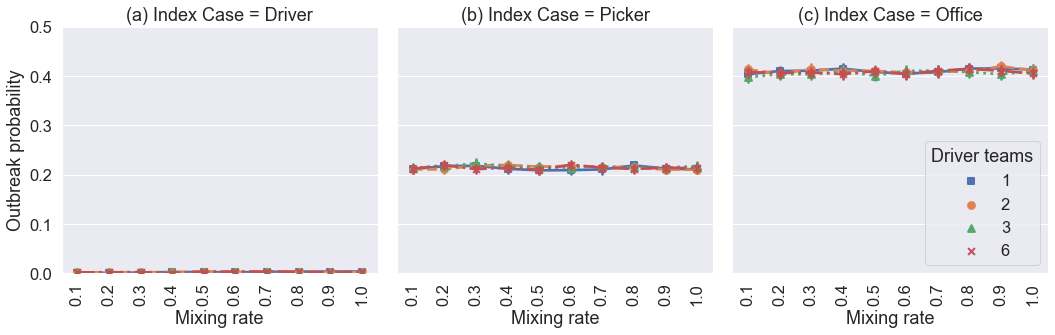

In [16]:
sp = sns.catplot(x='phi',y='outbreak', hue='NOteams',col='InfInit',data=dfNOT,kind='point',\
                 markers=["s","o","^","x"], linestyles=["-", "--",":","-."], legend=False)
sp.set(xlabel='Mixing rate',ylim=(0,0.5))
axes = sp.axes.flatten()
axes[0].set_ylabel('Outbreak probability')
lab = ['a','b','c']
for i in range(3):
    axes[i].set_title('(%s) Index Case = %s'%(lab[i],job[i]))
sp.set_xticklabels(rotation=90)
plt.legend(loc='lower right',title='Office teams')
plt.tight_layout()
sp.savefig('param_sweep_outbreak_probability_NOT.png')

/Users/carlwhitfield/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


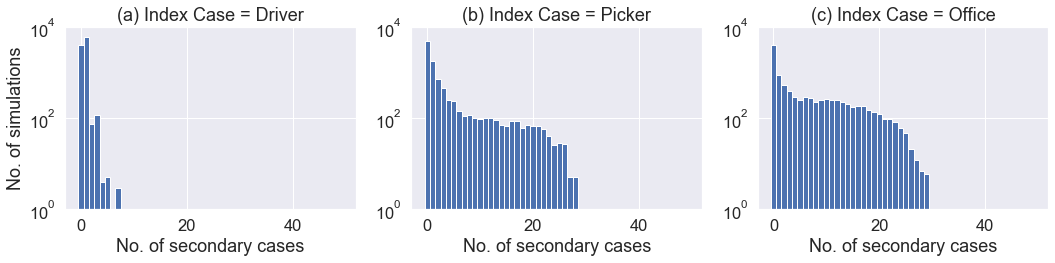

In [17]:
fig, ax = plt.subplots(1,3,figsize=(15,4))
ntd = 2
nphi = 0
for (i,ii) in enumerate(II):
    dfh = dfall[(dfall['InfInit'] == ii)*(dfall['NDteams']==3)*(dfall['NLteams']==2)*(dfall['NOteams']==2)*(dfall['phi']==Phi[nphi])]
    ax[i].hist(dfh['Ninfected'],bins=(np.arange(51)-0.5),label='%.2f'%Phi[nphi])
    ax[i].set_yscale('log')
    ax[i].set_ylim((1,10000))
    ax[i].set_title('(%s) Index Case = %s'%(lab[i],job[i]))
    ax[i].set_xlabel('No. of secondary cases')
ax[0].set_ylabel('No. of simulations')
fig.tight_layout()
fig.savefig('secondary_cases_hist.png')

Count customer infections

In [ ]:
dfh = df[lambda df: (df['phi'] == Phi[0]) | (df['phi'] == Phi[2]) | (df['phi'] == Phi[4])]

sp = sns.catplot(x='tD',y='CustomersInfectedByDrivers',col='InfInit',hue='phi',data=dfh,\
                 markers=["s","o","^"],linestyles=["-", "--",":"], kind='point',legend=False)
sp.set(ylim=(0,3.0),xlabel='Driver contact rate')
axes = sp.axes.flatten()
axes[0].set_ylabel('Customers infected per simulation')
lab = ['a','b','c']
for i in range(3):
    axes[i].set_title('(%s) Index Case = %s'%(lab[i],job[i]))
plt.legend(loc='upper left',title='Mixing param')
sp.set_xticklabels(rotation=90)
sp.savefig('Customer_infections.png')

Only weak dependence on phi, and only for small phi. Might be worth showing how NN contacts for each group varies with phi and workplace size

In [61]:
#breakdown of infection causes in the model
jobtypes = np.unique(df['Group'])
print(jobtypes)
netinfs = np.zeros((len(jobtypes),len(TDists),len(II)))
continfs = np.zeros((len(jobtypes),len(TDists),len(II)))
roominfs = np.zeros((len(jobtypes),len(TDists),len(II)))
carinfs = np.zeros((len(jobtypes),len(TDists),len(II)))
houseinfs = np.zeros((len(jobtypes),len(TDists),len(II)))
dfh = df.loc[lambda df: (df['NDteams']==3)*(df['NLteams']==2)*(df['NOteams']==2)]
for (n, g) in enumerate(jobtypes):
    dfg = dfh.loc[lambda dfh: (dfh['Group'] == g)]
    for (j,phi) in enumerate(TDists):
        dfij =  dfg.loc[lambda dfg: (dfg['TeamDistances'] == phi)]
        for (k,ii) in enumerate(II):
            dfijk =  dfij.loc[lambda dfij: (dfij['InfInit'] == ii)]

            netinfs[n,j,k] = np.mean(dfijk['CohortInfectionFrac']*dfijk['NStaff'])
            continfs[n,j,k] = np.mean(dfijk['RandContactInfectionFrac']*dfijk['NStaff'])
            roominfs[n,j,k] = np.mean(dfijk['RoomInfectionFrac']*dfijk['NStaff'])
            carinfs[n,j,k] = np.mean(dfijk['CarShareInfFrac']*dfijk['NStaff'])
            houseinfs[n,j,k] = np.mean(dfijk['HouseShareInfFrac']*dfijk['NStaff'])
# for (i,td) in enumerate(TD):
#     for (j,phi) in enumerate(Phi):
#         for (k,ii) in enumerate(II):
#             norm = netinfs[jobtypes=='All',i,j,k][0] + \
#                    continfs[jobtypes=='All',i,j,k][0] + \
#                    roominfs[jobtypes=='All',i,j,k][0]
#             if norm > 0:
#                 for (n, g) in enumerate(jobtypes): 
#                     netinfs[n,i,j,k] /= norm
#                     continfs[n,i,j,k] /= norm
#                     roominfs[n,i,j,k] /= norm

['All' 'Drivers' 'Office' 'Pickers']


In [40]:
np.max(houseinfs)

0.0

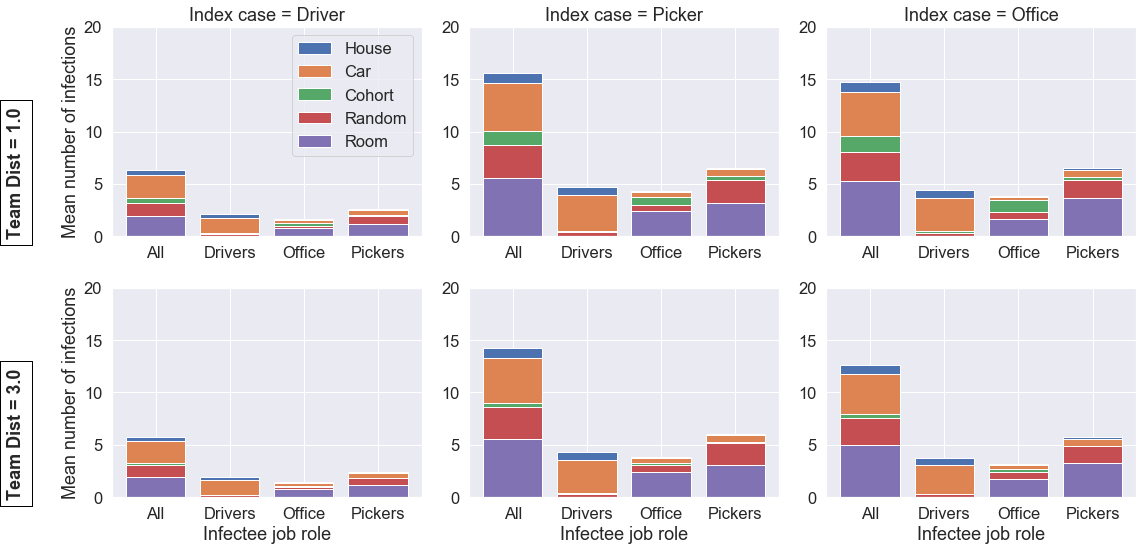

In [64]:
fig,ax = plt.subplots(2,3,figsize=(16,8))                
for k in np.arange(3):
    for (i,n) in enumerate([0,len(TDists)-1]):
        ax[i,k].bar(jobtypes, houseinfs[:,n,k] + carinfs[:,n,k] + \
                              netinfs[:,n,k] + continfs[:,n,k] + \
                              roominfs[:,n,k],label='House')
        ax[i,k].bar(jobtypes, carinfs[:,n,k] + netinfs[:,n,k] + \
                              continfs[:,n,k] + roominfs[:,n,k],\
                              label='Car')

        ax[i,k].bar(jobtypes, netinfs[:,n,k] + continfs[:,n,k] + \
                              roominfs[:,n,k],label='Cohort')
        ax[i,k].bar(jobtypes, continfs[:,n,k] + roominfs[:,n,k],\
                              label='Random')
        ax[i,k].bar(jobtypes, roominfs[:,n,k],label='Room')
        ax[i,0].set_ylabel('Mean number of infections')
        ax[i,k].set_ylim((0,20.0))
        ax[i,0].text(-2.0, 0.2, 'Team Dist = %.1f'%TDists[n], rotation='vertical',fontweight='bold',\
            bbox={'facecolor': 'white', 'alpha': 1.0, 'pad': 7.0, 'linestyle': '-',\
                  'edgecolor': 'black'})
    ax[0,k].set_title('Index case = %s'%job[k])
    
    ax[1,k].set_xlabel('Infectee job role')
    

ax[0,0].legend()
fig.tight_layout()
fig.savefig('infection_routes.png')
####need to extract for tD = 0.25, like the rest

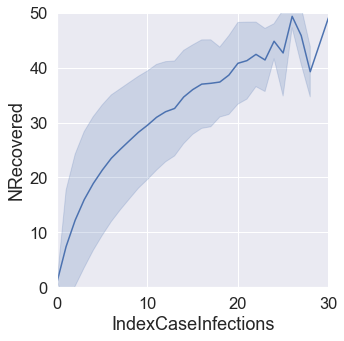

In [15]:
extreme_cases_df = df.loc[lambda df: (df['Group']=='All') & (df['FracRecovered']>10/df['NStaff'])]
#plt.hist(extreme_cases_df['FracRecovered'],bins=20)
figh = sns.relplot(x='IndexCaseInfections',y='NRecovered',data=df.loc[lambda df: (df['Group']=='All')],\
                   kind='line',ci='sd')
figh.set(xlim=(0,30),ylim=(0,50))

In [16]:
job_roles = ['Drivers','Pickers','Office']
phisel = [0.05,1.0]

second_infs_mean = np.zeros((len(job_roles),len(TD),len(phisel),len(II)))
second_infs_std = np.zeros((len(job_roles),len(TD),len(phisel),len(II))) 
for i in np.arange(len(job_roles)):
    dfi = df.loc[lambda df: (df['Group'] == job_roles[i])]
    for j in np.arange(len(TD)):
        dfij = dfi.loc[lambda df: (df['tD'] == TD[j])]
        for k in np.arange(len(phisel)):
            dfijk = dfij.loc[lambda df: (df['phi'] == phisel[k])]
            for n in np.arange(len(II)):
                dfh = dfijk.loc[lambda df: (df['InfInit'] == II[n])]
                if i == n:
                    second_infs_mean[i,j,k,n] = np.mean(dfh['NRecovered']-1)
                    second_infs_std[i,j,k,n] = np.std(dfh['NRecovered']-1)
                else:
                    second_infs_mean[i,j,k,n] = np.mean(dfh['NRecovered'])
                    second_infs_std[i,j,k,n] = np.std(dfh['NRecovered'])

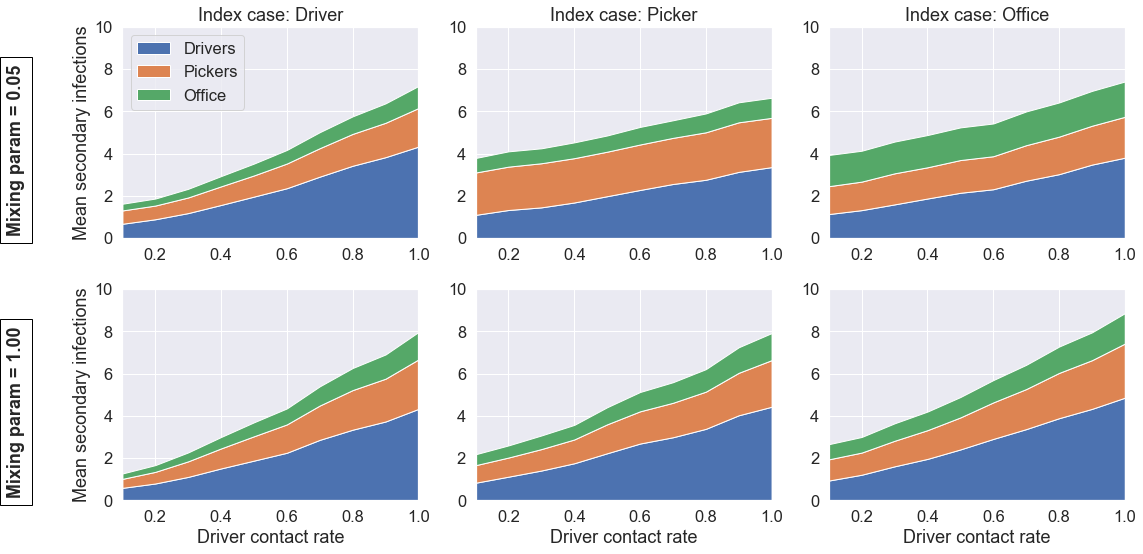

In [19]:
fig, ax = plt.subplots(2,3,figsize=(16,8))

for k in np.arange(len(phisel)):  #row
    for n in np.arange(len(II)):  #col
        ax[k,n].stackplot(TD,[second_infs_mean[0,:,k,n],second_infs_mean[1,:,k,n],\
                                second_infs_mean[2,:,k,n]],labels=job_roles)
        ax[k,n].set_xlim((0.1,1))
        ax[k,n].set_ylim((0,10.0))
        #for i in np.arange(len(job_roles)):
        #ax[k,n].errorbar(TD,np.sum(second_infs_mean[0:i,:,k,n],0),second_infs_std[i,:,k,n])
        ax[1,n].set_xlabel('Driver contact rate')
        ax[0,n].set_title('Index case: %s'%job[n])
    ax[k,0].set_ylabel('Mean secondary infections')
    ax[k,0].text(-0.25, 0.3, 'Mixing param = %.2f'%phisel[k], rotation='vertical',fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 1.0, 'pad': 7.0, 'linestyle': '-',\
                       'edgecolor': 'black'})
ax[0,0].legend(loc='upper left')

fig.tight_layout(pad=1)
fig.savefig('secondary_cases_cumulative.png')

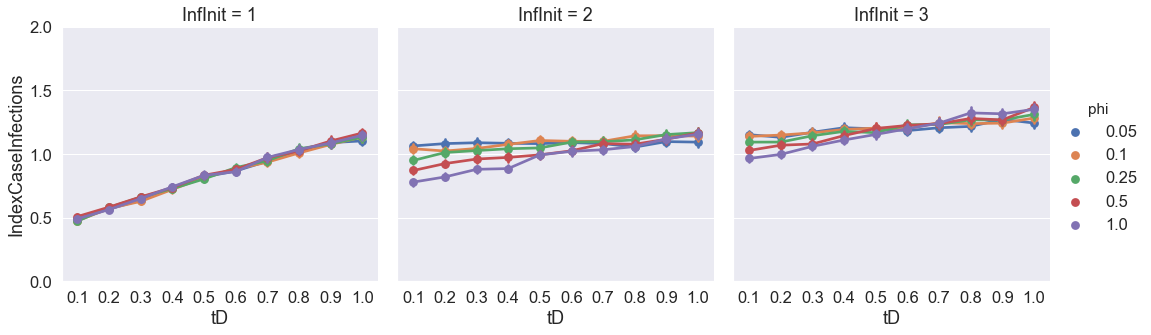

In [25]:
extreme_cases_df = dfall.loc[lambda df: (df['FracRecovered']>10/df['NStaff'])]
#plt.hist(extreme_cases_df['FracRecovered'],bins=20)
figh = sns.catplot(x='tD',y='IndexCaseInfections',col='InfInit',hue='phi',data=dfall,\
                   kind='point')
figh.set(ylim=(0,2))

count customers infected